In [ ]:
#!pip install -U fastai
! git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
! pip install -e ./Ranger-Deep-Learning-Optimizer/

Cloning into 'Ranger-Deep-Learning-Optimizer'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 135 (delta 34), reused 17 (delta 6), pack-reused 69
Receiving objects: 100% (135/135), 181.12 KiB | 7.24 MiB/s, done.
Resolving deltas: 100% (59/59), done.
Obtaining file:///content/Ranger-Deep-Learning-Optimizer
  Running setup.py develop for ranger


In [ ]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.metrics import *
from fastai.callbacks import *
from ranger import Ranger

import warnings 
warnings.filterwarnings('ignore')


In [ ]:
import fastai
fastai.__version__

'1.0.61'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Skin Cancer Example

## Data Loader

In [ ]:
path = Path("/content/drive/My Drive/skin_seg/")
path.ls()

[PosixPath('/content/drive/My Drive/skin_seg/segment'),
 PosixPath('/content/drive/My Drive/skin_seg/original'),
 PosixPath('/content/drive/My Drive/skin_seg/export.pkl'),
 PosixPath('/content/drive/My Drive/skin_seg/skin_segmentation.ipynb')]

In [ ]:
image_path = path/"original"
segment_path = path/"segment"
codes = array(['BG','tumor'])


In [ ]:
fnames = get_image_files(image_path)
lblnames = get_image_files(segment_path)

torch.Size([3, 1129, 1504])


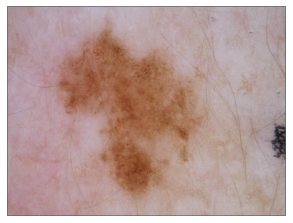

In [ ]:
img_f = fnames[2]
img = open_image(img_f)
print(img.shape)
img.show(figsize=(5,5))

torch.Size([1, 1129, 1504])


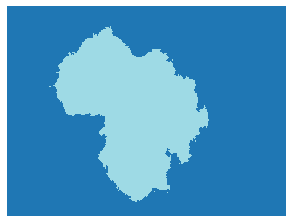

In [ ]:
get_y_fn = lambda o: segment_path/f'{o.stem}_segmentation.png'
mask = open_mask(get_y_fn(img_f), div=True)
print(mask.shape)
mask.show(figsize=(5,5), alpha=1)


In [ ]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: 
  bs=8
else:           
  bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 15068MB of GPU RAM free


In [ ]:
bs = 8
size = 500 #src_size//2


class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

src = (SegItemListCustom.from_folder(image_path)
        .split_by_rand_pct(0.2, seed=15)
        .label_from_func(get_y_fn, classes=codes ))
tfms = get_transforms() #get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=0.3)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
data

ImageDataBunch;

Train: LabelList (229 items)
x: SegItemListCustom
Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500)
y: SegLabelListCustom
ImageSegment (1, 500, 500),ImageSegment (1, 500, 500),ImageSegment (1, 500, 500),ImageSegment (1, 500, 500),ImageSegment (1, 500, 500)
Path: /content/drive/My Drive/skin_seg/original;

Valid: LabelList (57 items)
x: SegItemListCustom
Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500)
y: SegLabelListCustom
ImageSegment (1, 500, 500),ImageSegment (1, 500, 500),ImageSegment (1, 500, 500),ImageSegment (1, 500, 500),ImageSegment (1, 500, 500)
Path: /content/drive/My Drive/skin_seg/original;

Test: None

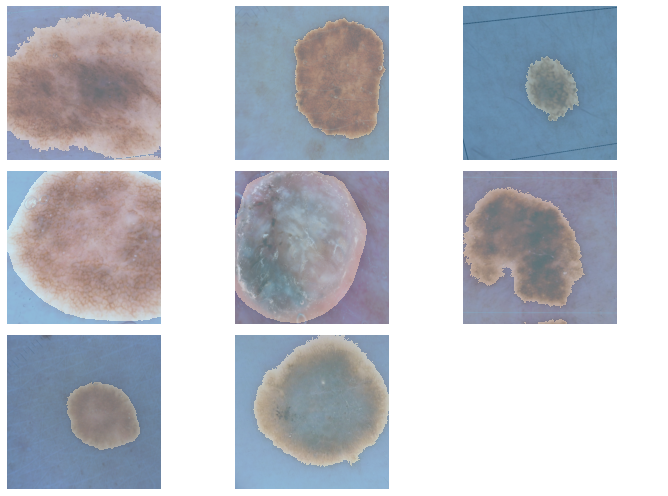

In [ ]:
data.show_batch(4, figsize=(10,7))

## Model Training

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
print(name2id)
void_code = name2id['BG']

def tumour(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

{'BG': 0, 'tumor': 1}


In [ ]:
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=1., gamma=1.):
#         super().__init__()
#         self.alpha = alpha
#         self.gamma = gamma

#     def forward(self, inputs, targets, **kwargs):
#         CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
#         pt = torch.exp(-CE_loss)
#         F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
#         return F_loss.mean()
    
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

### Ranger opt

In [ ]:
metrics=[tumour, dice]
wd = 0.2
learn = unet_learner(data, models.resnet34, wd=wd, metrics=metrics, opt_func = Ranger)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth



Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


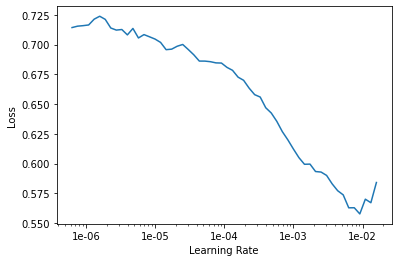

In [ ]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,tumour,dice,time
0,0.607195,0.447328,0.815967,0.757626,01:16
1,0.447094,0.249884,0.863823,0.859816,00:50
2,0.364813,0.220713,0.869545,0.877284,00:49
3,0.299374,0.196759,0.888699,0.883719,00:49
4,0.257476,0.266900,0.789746,0.858319,00:50
5,0.235514,0.172289,0.893237,0.904858,00:49
6,0.214967,0.185418,0.935750,0.888713,00:49
7,0.204621,0.173713,0.898096,0.899794,00:49
8,0.187975,0.172844,0.896571,0.901307,00:49
9,0.174296,0.167481,0.904087,0.905222,00:49


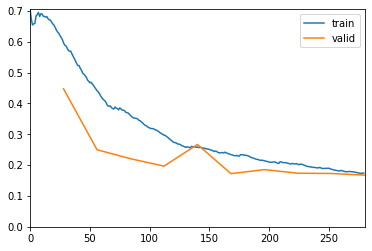

Better model found at epoch 0 with dice value: 0.7576259970664978.
Better model found at epoch 1 with dice value: 0.8598160743713379.
Better model found at epoch 2 with dice value: 0.8772836923599243.
Better model found at epoch 3 with dice value: 0.8837185502052307.
Better model found at epoch 5 with dice value: 0.9048575758934021.
Better model found at epoch 9 with dice value: 0.9052216410636902.
set state called


In [ ]:
fname="unet34-small-best"
patience=3
callbacksFitBeforeUnfreeze = [
    ShowGraph(learn),
    EarlyStoppingCallback(learn, monitor="valid_loss", patience=patience),
    SaveModelCallback(learn, monitor="dice", mode='max', name=fname)  
]

learn.fit_one_cycle(10, slice(1e-3), callbacks=callbacksFitBeforeUnfreeze)

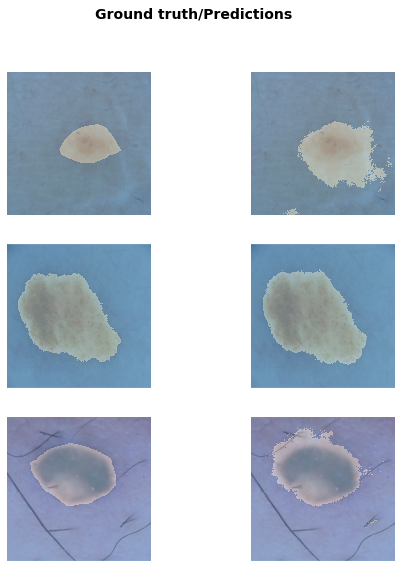

In [ ]:
learn.show_results(rows=3, figsize=(8,9))

In [ ]:
learn.load(path/'Unet_ranger-1')

In [ ]:
learn.save(path/'Unet_ranger-1')

In [ ]:
learn.load('unet34-small-best')

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch,train_loss,valid_loss,tumour,dice,time
0,0.156757,0.169929,0.903618,0.904056,00:51
1,0.151504,0.174814,0.897738,0.901452,00:51
2,0.151667,0.168780,0.915207,0.905247,00:51
3,0.154207,0.171902,0.916103,0.902277,00:51
4,0.154871,0.169398,0.922066,0.905651,00:51
5,0.150572,0.173040,0.908321,0.904706,00:51


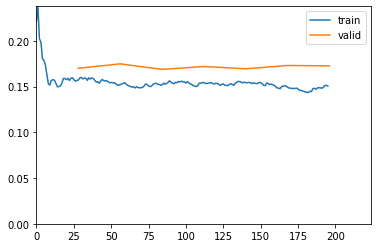

Better model found at epoch 0 with dice value: 0.9040558338165283.
Better model found at epoch 2 with dice value: 0.9052474498748779.
Better model found at epoch 4 with dice value: 0.9056506752967834.
Epoch 6: early stopping
set state called


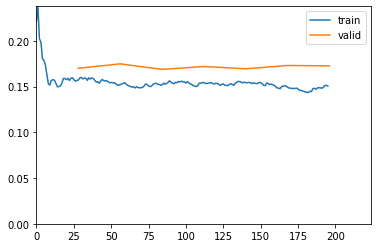

In [ ]:
learn.unfreeze()

fname="unet34-unfreeze-small-best"
patience=3
callbacksFitAfterUnfreeze = [
    ShowGraph(learn),
    EarlyStoppingCallback(learn, monitor="valid_loss", patience=patience),
    SaveModelCallback(learn, monitor="dice", mode='max', name=fname)  
]

lr=1e-3
lrs = slice(lr/400,lr/4)
learn.fit_one_cycle(8, lrs, pct_start=0.8, callbacks=callbacksFitAfterUnfreeze)

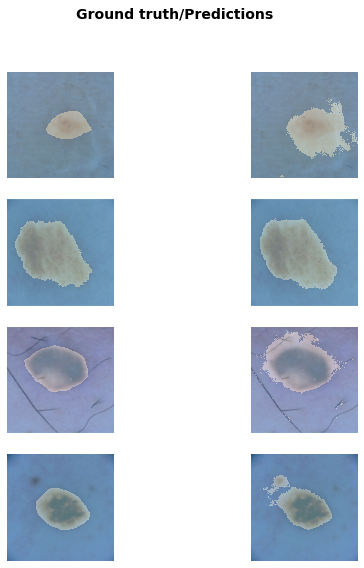

In [ ]:
learn.show_results(rows=4, figsize=(8,9))

In [ ]:
learn.export(path/'Unet-res34-deploy.pkl') 

## Inference

In [ ]:
codes = array(['BG','tumor'])
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['BG']

def tumour(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [ ]:
learn_inf = load_learner(path, 'Unet-res34-deploy.pkl')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ISIC_0072114-copy.jpg to ISIC_0072114-copy.jpg


In [ ]:
test_img_path = Path('/content/ISIC_0072114-copy.jpg')

torch.Size([3, 1024, 1024])


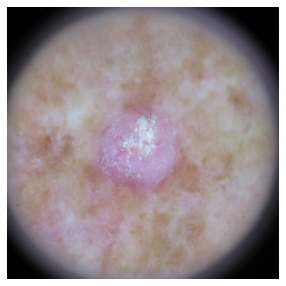

In [ ]:
test_img = open_image(test_img_path)
print(test_img.shape)
test_img.show(figsize=(5,5))

In [ ]:
pred, pred_vec, _ =learn_inf.predict(open_image(test_img_path))

torch.Size([1, 500, 500])


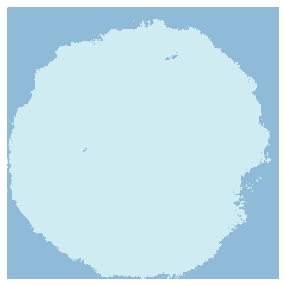

In [ ]:
print(pred.shape)
pred.show(figsize=(5,5))

In [ ]:
def print_segment(img, pred):
  img.resize(torch.Size([3, pred.shape[1], pred.shape[2]]))
  mask = np.stack((pred.data,pred.data,pred.data)).reshape(3, pred.shape[1], pred.shape[2])  # expand mask to 3D array
  mask_bool = np.stack((pred.data>0,pred.data>0,pred.data>0)).reshape(3, pred.shape[1], pred.shape[2])  # boolean
  img = np.array(img.data)  # convert Tensor to numpy array
  np.copyto(img, mask, where=np.invert(mask_bool))
  img = torch.from_numpy(img)
  plt.imshow(img.permute(1, 2, 0), interpolation='nearest')

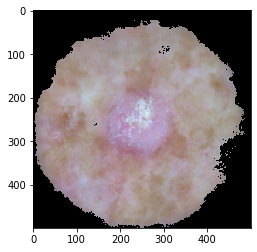

In [ ]:
print_segment(test_img, pred)